# Pk Emulator

## PCA+InterPol Method

In [1]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from numpy import linalg
from sklearn.decomposition import PCA

class Log_lin_Pk_emulator:
    def __init__(self, n_train, n_k, n_evecs, new = False):
        
        self.n_evecs = n_evecs
        self.k_arr = np.logspace(-4.7,5, n_k)
        self.wc_arr  = np.linspace(0.01, 1, 3*n_train)
        self.h_arr  = np.linspace(0.6,  0.9, n_train)
        
        if new:
            self.grid = []
            for i in range(len(self.wc_arr)):
                for j in range(len(self.h_arr)):
                    self.grid.append(self._get_theory_Pk(self.wc_arr[i], self.h_arr[j]))
            self.grid = np.array(self.grid)
                
            np.savetxt('Pk_grid.txt', self.grid)
        else:
            self.grid = np.loadtxt('Pk_grid.txt')
        
        self.log_grid = np.log(self.grid)
        self.mean_log_grid = np.mean(np.log(self.grid), axis=0) #avg over all cosmologies
        self.clean_grid = self.log_grid - self.mean_log_grid
        
        self.evecs = None
        self.w_arr = None
        self.w_emulator = None
        
        
        
        return 
            
    
    def get_evecs(self, manual = False):
        if self.evecs is None:
            if not manual:
                print('Manual:', manual)
                pca = PCA(n_components=self.n_evecs)
                self.evecs = pca.fit_transform(np.transpose(self.clean_grid))
                self.evecs = np.transpose(self.evecs)
            else:
                print('Manual:', manual)
                cov = np.cov(np.transpose(self.clean_grid))
                self.evals, self.evecs = linalg.eig(cov)
                #right to left vectors
                self.evecs = np.transpose(self.evecs)
                self.evecs = self.evecs[:self.n_evecs]
                #back to right
                self.evecs = np.transpose(self.evecs)
                #print(self.evals)        
        return self.evecs

    
    def get_w_arr(self):
        if self.w_arr is None:
            self.w_arr = []
            l=0
            for i in range(len(self.wc_arr)):
                row = []
                for j in range(len(self.h_arr)):
                    #Pk_ij = self._get_theory_Pk(self.wc_arr[i], self.h_arr[j])
                    Pk_ij = self.grid[l]
                    l = l + 1
                    w_ij = self._get_weigths(Pk_ij)
                    row.append(w_ij)
                self.w_arr.append(row)
                
        self.w_arr = np.transpose(np.array(self.w_arr))       
        return self.w_arr
    
    def get_w_emulator(self):
        if self.w_emulator is None:
            self.w_emulator={}
            w =0
            for grid in self.w_arr:
                w_i_emulator = scipy.interpolate.interp2d( self.wc_arr, self.h_arr, grid, kind='cubic')
                self.w_emulator["w_{}".format(w)]= w_i_emulator
                w = w+1
        return self.w_emulator
    
    def _get_weigths(self, Pk):
        y = np.log(Pk) - self.mean_log_grid
        return np.linalg.lstsq(self.evecs, y, rcond=None)[0]
        
    def _get_theory_Pk(self, wc, h):
        cosmo = ccl.Cosmology(Omega_c=wc, Omega_b=0.049, h=h, sigma8=0.81, n_s=0.96)
        return ccl.power.linear_matter_power(cosmo, self.k_arr, 1)
        
    def _get_evec_Pk(self, weigths , evecs, mean):
        return mean + np.sum(evecs*weigths, axis=1) 
    
    def get_emulated_Pk(self, h, wc):
        #log lin_Pk
        w_vec = []
        for i in range(self.n_evecs):
            w_i=self.w_emulator["w_{}".format(i)](h, wc)[0]
            w_vec.append(w_i)
        w_vec = np.array(w_vec) 
        Pk = self._get_evec_Pk(w_vec, self.evecs, self.mean_log_grid)
        return self.k_arr, np.array(Pk)
    
    

In [2]:
emulator_10 = Log_lin_Pk_emulator(10, 200, 10, new=True)
emulator_7 = Log_lin_Pk_emulator(10, 200, 7, new=True)
emulator_3 = Log_lin_Pk_emulator(10, 200, 3, new=True)

In [3]:
evecs = emulator_10.get_evecs(manual = True);
emulator_7.get_evecs(manual = True);
emulator_3.get_evecs(manual = True);

Manual: True
Manual: True
Manual: True


In [4]:
emulator_10.get_w_arr();
emulator_7.get_w_arr();
emulator_3.get_w_arr();

In [5]:
emulator_10.get_w_emulator();
emulator_7.get_w_emulator();
emulator_3.get_w_emulator();

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(


In [6]:
k_arr, emulated_10 = emulator_10.get_emulated_Pk(0.27,0.67)
k_arr, emulated_7 = emulator_7.get_emulated_Pk(0.27,0.67)
k_arr, emulated_3 = emulator_3.get_emulated_Pk(0.27,0.67)
emulated_10 = np.exp(emulated_10)
emulated_7 = np.exp(emulated_7)
emulated_3 = np.exp(emulated_3)

In [7]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
theory  = ccl.power.linear_matter_power(cosmo, k_arr, 1)

In [8]:
Pk_diff_10 = abs(emulated_10 -theory)
Pk_diff_7  = abs(emulated_7  -theory)
Pk_diff_3  = abs(emulated_3  -theory)

In [9]:
evecs = np.transpose(evecs)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


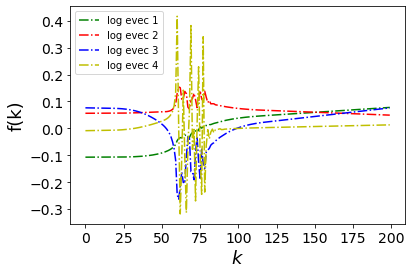

In [10]:
plt.plot(  evecs[0] , 'g-.', label = 'log evec 1' )
plt.plot(  evecs[1] , 'r-.', label = 'log evec 2' )
plt.plot(  evecs[2] , 'b-.', label = 'log evec 3' )
plt.plot(  evecs[3] , 'y-.', label = 'log evec 4' )

plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


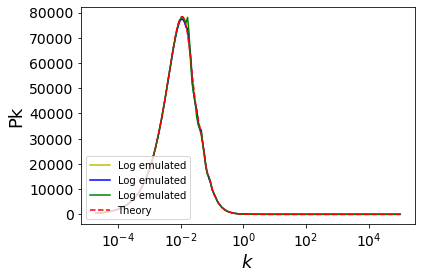

In [11]:
#plt.plot(k_arr, hand_emulated , 'g-', label = 'Hand emulated' )
#plt.plot(k_arr, pca_emulated , 'b--', label = 'PCA emulated' )
plt.plot(k_arr, emulated_10 , 'y-', label = 'Log emulated' )
plt.plot(k_arr, emulated_7 , 'b-', label = 'Log emulated' )
plt.plot(k_arr, emulated_3 , 'g-', label = 'Log emulated' )
plt.plot(k_arr, theory, 'r--', label = 'Theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Pk',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

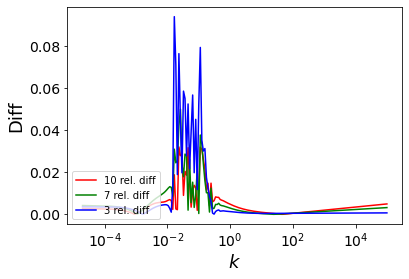

In [12]:
plt.plot(k_arr, Pk_diff_10/theory, 'r-', label = '10 rel. diff' )
plt.plot(k_arr, Pk_diff_7/theory, 'g-', label = '7 rel. diff' )
plt.plot(k_arr, Pk_diff_3/theory, 'b-', label = '3 rel. diff' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

In [13]:
def GoF(emulator, h_in, w_c_in):
    k, Pk_f = emulator.get_emulated_Pk(w_c_in, h_in)
    Pk_f = np.exp(Pk_f)
    
    cosmo = ccl.Cosmology(Omega_c=w_c_in, Omega_b=0.049, h=h_in, sigma8=0.81, n_s=0.96)
    Pk_t = ccl.power.linear_matter_power(cosmo, k, 1)
    
    N = np.sum(k**3)
    rel_diff = abs(Pk_t-Pk_f)/Pk_t
    D =np.sum(k**3*rel_diff**2)
    #print(D, rel_diff, N)
    
    return np.sqrt(D/N)

def max_diff(emulator, h_in, w_c_in):
    k, Pk_f = emulator.get_emulated_Pk(w_c_in, h_in)
    Pk_f = np.exp(Pk_f) 
    cosmo = ccl.Cosmology(Omega_c=w_c_in, Omega_b=0.049, h=h_in, sigma8=0.81, n_s=0.96)
    Pk_t = ccl.power.linear_matter_power(cosmo, k, 1)
    rel_diff = abs(Pk_t-Pk_f)/Pk_t

    return max(rel_diff)

In [14]:
samples = 100
h_smp = 0.6 + (0.9-0.6)*np.random.rand(samples)
wc_smp = 0.1 + (1-0.1)*np.random.rand(samples)


gof_3= []
for i in range(samples):
    gof_3.append(GoF(emulator_3, h_smp[i], wc_smp[i]))
gof_3 = np.array(gof_3) 

max_diff_arr_3= []
for i in range(samples):
    max_diff_arr_3.append(max_diff(emulator_3, h_smp[i], wc_smp[i]))
max_diff_arr_3 = np.array(max_diff_arr_3)

gof_7= []
for i in range(samples):
    gof_7.append(GoF(emulator_7, h_smp[i], wc_smp[i]))
gof_7 = np.array(gof_7) 

max_diff_arr_7= []
for i in range(samples):
    max_diff_arr_7.append(max_diff(emulator_7, h_smp[i], wc_smp[i]))
max_diff_arr_7 = np.array(max_diff_arr_7)


gof_10= []
for i in range(samples):
    gof_10.append(GoF(emulator_10, h_smp[i], wc_smp[i]))
gof_10 = np.array(gof_10) 

max_diff_arr_10= []
for i in range(samples):
    max_diff_arr_10.append(max_diff(emulator_10, h_smp[i], wc_smp[i]))
max_diff_arr_10 = np.array(max_diff_arr_10)  

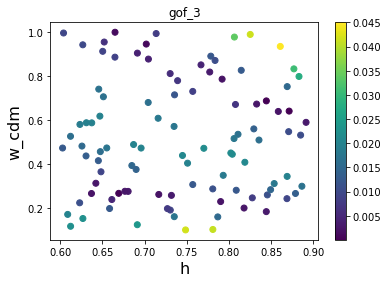

In [15]:
plt.scatter(h_smp, wc_smp, c = gof_3)
plt.title('gof_3')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

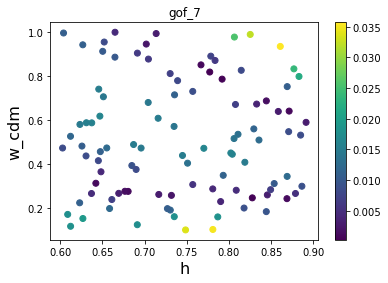

In [16]:
plt.scatter(h_smp, wc_smp, c = gof_7)
plt.title('gof_7')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

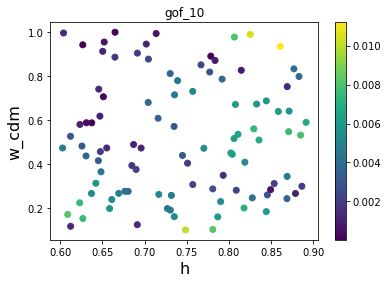

In [17]:
plt.scatter(h_smp, wc_smp, c = gof_10)
plt.title('gof_10')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

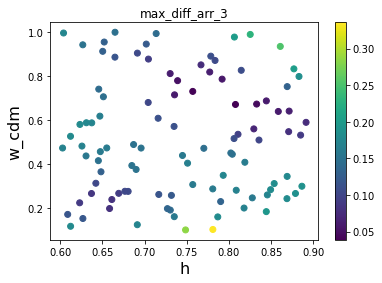

In [18]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_3)
plt.title('max_diff_arr_3')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

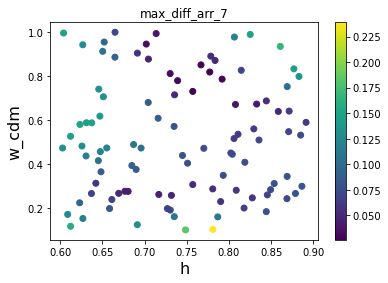

In [19]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_7)
plt.title('max_diff_arr_7')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

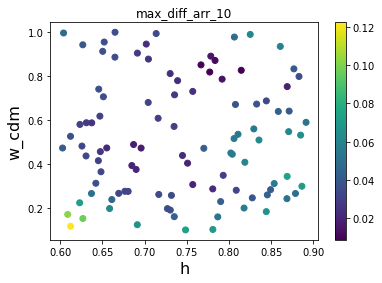

In [20]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_10)
plt.title('max_diff_arr_10')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()